
# 03 — LLM Cleanup (Robust)

Cleans a subset of noisy OCR blocks with a local Ollama model (with fallback).  
Writes the model output to `text_llm` and a chosen `text_final` while preserving original text.


In [9]:

# --- PARAMETERS (papermill can override) ---
blocks_dir = "outputs/run_001/02_cleaned"
output_dir = "outputs/run_001/03_llmcleaned"
model = "alibayram/medgemma:latest"
fallback_model = "mistral:7b"
max_cleanups = 60
per_file_cap = 30
timeout_seconds = 40
print_every = 10


In [10]:

# --- IMPORTS & SETUP ---
import os, re, json, time, concurrent.futures, requests, difflib
from pathlib import Path
from typing import List, Dict, Any, Tuple
from collections import Counter

from langchain.prompts import PromptTemplate
try:
    from langchain_ollama import ChatOllama
except Exception:
    from langchain_community.chat_models import ChatOllama
from langchain.schema import StrOutputParser

blocks_dir = Path(blocks_dir).expanduser().resolve()
output_dir = Path(output_dir).expanduser().resolve()
output_dir.mkdir(parents=True, exist_ok=True)
print("[INFO] blocks_dir:", blocks_dir)
print("[INFO] output_dir:", output_dir)


[INFO] blocks_dir: /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/02_cleaned
[INFO] output_dir: /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/03_llmcleaned


In [11]:

# --- DISCOVER INPUT FILES ---
def discover_source_folder(root: Path) -> Path:
    if any(root.glob("page_*_*.json")):
        return root
    for sub in ["02_cleaned", "01_blocks", "03_llmcleaned"]:
        cand = root / sub
        if cand.exists() and any(cand.glob("page_*_*.json")):
            return cand
    return root

src = discover_source_folder(blocks_dir)
print(f"[INFO] Using source folder: {src}")
patterns = ["page_*_blocks.domain.json", "page_*_blocks.cleaned.json", "page_*_blocks.json"]
files = []
for pat in patterns:
    found = sorted(src.glob(pat))
    if found:
        files = found
        print(f"[INFO] Found {len(files)} files via pattern '{pat}'")
        break
if not files:
    raise FileNotFoundError(f"No page_* block files found under {src}")


[INFO] Using source folder: /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/02_cleaned
[INFO] Found 4 files via pattern 'page_*_blocks.domain.json'


In [12]:

# --- HELPERS ---
def detect_lang_tag(s: str) -> str:
    if any('\u0900' <= c <= '\u097F' for c in s): return "hi"
    if any('\u0C00' <= c <= '\u0C7F' for c in s): return "te"
    return "en"

def ollama_model_available(name: str, base: str="http://localhost:11434") -> bool:
    try:
        r = requests.get(f"{base}/api/tags", timeout=3)
        r.raise_for_status()
        tags = r.json().get("models", [])
        return any(m.get("name")==name for m in tags)
    except Exception:
        return False

PROMPT_BASE = (
    "You are a medical text cleaner.\n"
    "Fix OCR/spelling without changing facts. Preserve all medical terms, abbreviations, and numbers."
    "{note}\n\nText:\n{t}"
)
prompt_template = PromptTemplate.from_template(PROMPT_BASE)
fmt = StrOutputParser()

def make_llm(name: str):
    try:
        return ChatOllama(model=name, temperature=0, model_kwargs={"keep_alive":0})
    except Exception as e:
        print(f"[WARN] Could not init LLM '{name}':", e)
        return None

def run_with_timeout(fn, *args, timeout_s=40, **kw):
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as ex:
        fut = ex.submit(fn, *args, **kw)
        return fut.result(timeout=timeout_s)

def llm_clean(chain, payload: dict, fallback_chain=None, timeout_s=40) -> str:
    try:
        out = run_with_timeout(chain.invoke, payload, timeout_s, {})
        return (out or "").strip()
    except Exception:
        if fallback_chain:
            try:
                out = run_with_timeout(fallback_chain.invoke, payload, timeout_s, {})
                return (out or "").strip()
            except Exception:
                return ""
        return ""


In [13]:

def should_cleanup(t: str) -> bool:
    if not t or not t.strip(): return False
    t=t.strip()
    noisy = ["@@","##","| |","¢","§","�","~~","==","… …","||","— —"]
    if any(x in t for x in noisy): return True
    # NEW: trigger on mixed-caps OCR-ish patterns / suspicious punctuation clusters
    if re.search(r"[A-Za-z]\d[A-Za-z]|\b[l1I]{3,}\b|[.,;:]{3,}", t): return True
    # Short unpunctuated lines (labels/headers) get normalized too
    if len(t) < 25 and not re.search(r"[.!?]$", t): return True
    return False

def digits_pattern(s: str):
    return re.findall(r"\d+(?:\.\d+)?", s or "")

def choose_text(orig: str, cleaned02a: str|None, llm_out: str|None):
    candidates = [("orig", orig)]
    if cleaned02a and cleaned02a.strip(): candidates.append(("02a", cleaned02a))
    if llm_out and llm_out.strip():       candidates.append(("llm", llm_out))
    base = orig or ""
    def score(v: str):
        sim = difflib.SequenceMatcher(None, base, v).ratio()
        nums_ok = digits_pattern(base) == digits_pattern(v)
        len_ratio = (len(v)+1)/(len(base)+1) if base else 1.0
        len_penalty = 0.0 if 0.5 <= len_ratio <= 1.5 else 0.1
        return (nums_ok, round(sim - len_penalty, 4))
    return max(candidates, key=lambda kv: score(kv[1]))


In [14]:

primary_ok = ollama_model_available(model)
fallback_ok = ollama_model_available(fallback_model) if fallback_model else False
print(f"[INFO] Primary model available: {model} → {primary_ok}")
print(f"[INFO] Fallback model available: {fallback_model} → {fallback_ok}")

llm = make_llm(model) if primary_ok else None
fallback_llm = make_llm(fallback_model) if fallback_ok else None
primary_chain = prompt_template | llm | fmt if llm else None
fallback_chain = prompt_template | fallback_llm | fmt if fallback_llm else None


[INFO] Primary model available: alibayram/medgemma:latest → True
[INFO] Fallback model available: mistral:7b → True


In [15]:

print("[INFO] Starting LLM cleanup...")
global_budget = int(max_cleanups)
touched_total = 0
run_stats = []

for f in files:
    if global_budget <= 0:
        print("[INFO] Global budget exhausted; stopping.")
        break
    blocks = json.loads(f.read_text(encoding="utf-8"))
    cleaned, n_done = [], 0
    kept_counter = Counter()
    edit_ratios = []
    for idx, b in enumerate(blocks):
        orig = (b.get("text") or "").strip()
        cleaned02a = (b.get("text_cleaned") or "").strip() if isinstance(b.get("text_cleaned"), str) else ""
        llm_out = ""
        do_llm = (primary_chain or fallback_chain) and global_budget>0 and n_done < int(per_file_cap) and should_cleanup(orig)
        if do_llm:
            lang = detect_lang_tag(orig)
            note = "\nNote: Text may include Indic script. Preserve non-English words exactly." if lang in ("hi","te") else ""
            payload = {"t": orig, "note": note}
            out = llm_clean(primary_chain, payload, fallback_chain=fallback_chain, timeout_s=int(timeout_seconds))
            if out.startswith("```"):
                out = re.sub(r"^```(?:json)?\s*", "", out).strip()
                out = re.sub(r"\s*```$", "", out).strip()
            llm_out = out
            if llm_out:
                n_done += 1
                global_budget -= 1
                if n_done % int(print_every) == 0:
                    print(f"[{f.name}] LLM cleaned {n_done} blocks so far...")
        label, chosen = choose_text(orig, cleaned02a, llm_out)
        kept_counter[label] += 1
        if orig:
            edit_ratios.append(difflib.SequenceMatcher(None, orig, chosen).ratio())
        nb = dict(b)
        nb.setdefault("text_orig", orig)
        if cleaned02a:
            nb["text_cleaned"] = cleaned02a
        if llm_out:
            nb["text_llm"] = llm_out
        nb["text_final"] = chosen
        cleaned.append(nb)
    out_file = output_dir / f"{f.stem}.llm.json"
    out_file.write_text(json.dumps(cleaned, ensure_ascii=False, indent=2), encoding="utf-8")
    stats = {
        "file": f.name,
        "blocks_total": len(blocks),
        "blocks_llm_touched": n_done,
        "avg_edit_ratio_vs_orig": round(sum(edit_ratios)/max(1,len(edit_ratios)), 4),
        "kept_version_counts": dict(kept_counter),
        "budget_remaining": global_budget
    }
    run_stats.append(stats)
    print(f"✓ {f.name}: touched={n_done}/{len(blocks)} avg_edit={stats['avg_edit_ratio_vs_orig']} kept={dict(kept_counter)}")

summary_path = output_dir / "_run_summary.json"
summary_path.write_text(json.dumps(run_stats, indent=2), encoding="utf-8")
print("\n=== Run Summary ===")
for s in run_stats:
    print(f"{s['file']}: touched={s['blocks_llm_touched']}/{s['blocks_total']} avg_edit={s['avg_edit_ratio_vs_orig']} kept={s['kept_version_counts']}")
print("\n✅ LLM cleanup complete →", output_dir)


[INFO] Starting LLM cleanup...
✓ page_001_blocks.domain.json: touched=0/8 avg_edit=1.0 kept={'orig': 8}
✓ page_002_blocks.domain.json: touched=0/12 avg_edit=1.0 kept={'orig': 12}
✓ page_003_blocks.domain.json: touched=0/8 avg_edit=1.0 kept={'orig': 8}
✓ page_004_blocks.domain.json: touched=0/9 avg_edit=1.0 kept={'orig': 9}

=== Run Summary ===
page_001_blocks.domain.json: touched=0/8 avg_edit=1.0 kept={'orig': 8}
page_002_blocks.domain.json: touched=0/12 avg_edit=1.0 kept={'orig': 12}
page_003_blocks.domain.json: touched=0/8 avg_edit=1.0 kept={'orig': 8}
page_004_blocks.domain.json: touched=0/9 avg_edit=1.0 kept={'orig': 9}

✅ LLM cleanup complete → /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/03_llmcleaned


Saved QA plot → outputs/run_001/03_llmcleaned/_qa_llmcleanup_summary.png


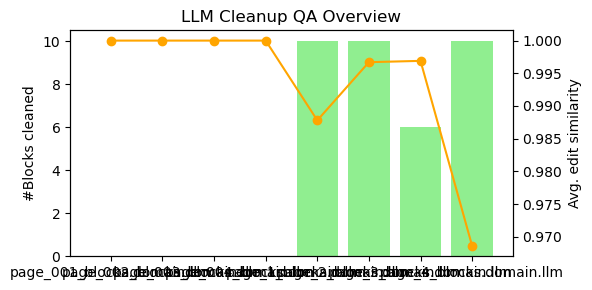

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import json, math
from pathlib import Path

run_dir = Path("outputs/run_001/03_llmcleaned")
stats = []
for f in sorted(run_dir.glob("page_*_*.json")):
    data = json.loads(f.read_text())
    touched = sum(1 for b in data if "text_llm" in b)
    total = len(data)
    avg_edit = round(sum(
        difflib.SequenceMatcher(None, b.get("text",""), b.get("text_llm",b.get("text",""))).ratio()
        for b in data
    )/total, 4) if total else 0
    stats.append({"page": f.stem, "touched": touched, "total": total, "avg_edit": avg_edit})
df = pd.DataFrame(stats)

fig, ax = plt.subplots(figsize=(6,3))
ax.bar(df["page"], df["touched"], color="lightgreen")
ax2 = ax.twinx()
ax2.plot(df["page"], df["avg_edit"], color="orange", marker="o")
ax.set_ylabel("#Blocks cleaned")
ax2.set_ylabel("Avg. edit similarity")
plt.title("LLM Cleanup QA Overview")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(run_dir/"_qa_llmcleanup_summary.png", dpi=150)
print("Saved QA plot →", run_dir/"_qa_llmcleanup_summary.png")
